# Project Proposal (Matt)

The ETL Project involved performing an Extract-Transform-Load (ETL) process on airline flight performance data and customer tweet data from February 2015. The members of the group are Sedra Kurdi, Myles Bridges, Natalie Myers, and Matthew Kennedy. The datasets chosen were found at https://www.kaggle.com/usdot/flight-delays and https://www.kaggle.com/crowdflower/twitter-airline-sentiment, and were in CSV and SQLite format respectively. The approach was to use the SQLAlchemy and Pandas modules in Python to extract and transform the data. SQLAlchemy was then used to load the transformed data into a PostgreSQL database.

# Project Code

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

## Data Extraction

### Flight Data (Myles & Sedra)

In [2]:
#ADD CODE HERE

### Tweet Data (Natalie)

In [10]:
engine = create_engine("sqlite:///Tweet_Data/database.sqlite")

In [11]:
# reflect an existing database into a new model
Base = automap_base()

In [12]:
# reflect the tables
Base.prepare(engine, reflect=True)

In [13]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [14]:
inspector = inspect(engine)
inspector.get_table_names()

['Tweets']

In [15]:
data_tweets = pd.read_sql_table('Tweets',engine)

data_tweets

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,567588278875213824,neutral,1.0000,,,Delta,,JetBlueNews,,0,@JetBlue's new CEO seeks the right balance to ...,,2015-02-16 23:36:05 -0800,USA,Sydney
1,567590027375702016,negative,1.0000,Can't Tell,0.6503,Delta,,nesi_1992,,0,@JetBlue is REALLY getting on my nerves !! 😡😡 ...,,2015-02-16 23:43:02 -0800,undecided,Pacific Time (US & Canada)
2,567591480085463040,negative,1.0000,Late Flight,0.346,United,,CPoutloud,,0,@united yes. We waited in line for almost an h...,,2015-02-16 23:48:48 -0800,"Washington, DC",
3,567592368451248130,negative,1.0000,Late Flight,1,United,,brenduch,,0,@united the we got into the gate at IAH on tim...,,2015-02-16 23:52:20 -0800,,Buenos Aires
4,567594449874587648,negative,1.0000,Customer Service Issue,0.3451,Southwest,,VahidESQ,,0,@SouthwestAir its cool that my bags take a bit...,,2015-02-17 00:00:36 -0800,"Los Angeles, CA",Pacific Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14480,570309308937842688,neutral,0.6869,,,Delta,,Oneladyyouadore,,0,@JetBlue I hope so because I fly very often an...,,2015-02-24 11:48:29 -0800,Georgia,Quito
14481,570309340952993796,neutral,1.0000,,,US Airways,,DebbiMcGinnis,,0,@USAirways is a DM possible if you aren't foll...,,2015-02-24 11:48:37 -0800,Missourah,Hawaii
14482,570309345281486848,positive,0.6469,,,Delta,,jaxbra,,0,@JetBlue Yesterday on my way from EWR to FLL j...,,2015-02-24 11:48:38 -0800,"east brunswick, nj",Atlantic Time (Canada)
14483,570310144459972608,negative,1.0000,Customer Service Issue,1,US Airways,,GAKotsch,,0,@USAirways and when will one of these agents b...,,2015-02-24 11:51:48 -0800,,Atlantic Time (Canada)


## Data Transformation

### Flight Data (Myles & Sedra)

In [ ]:
#ADD CODE HERE

### Tweet Data (Natalie)

In [ ]:
#ADD CODE HERE

## Data Loading (Matt)

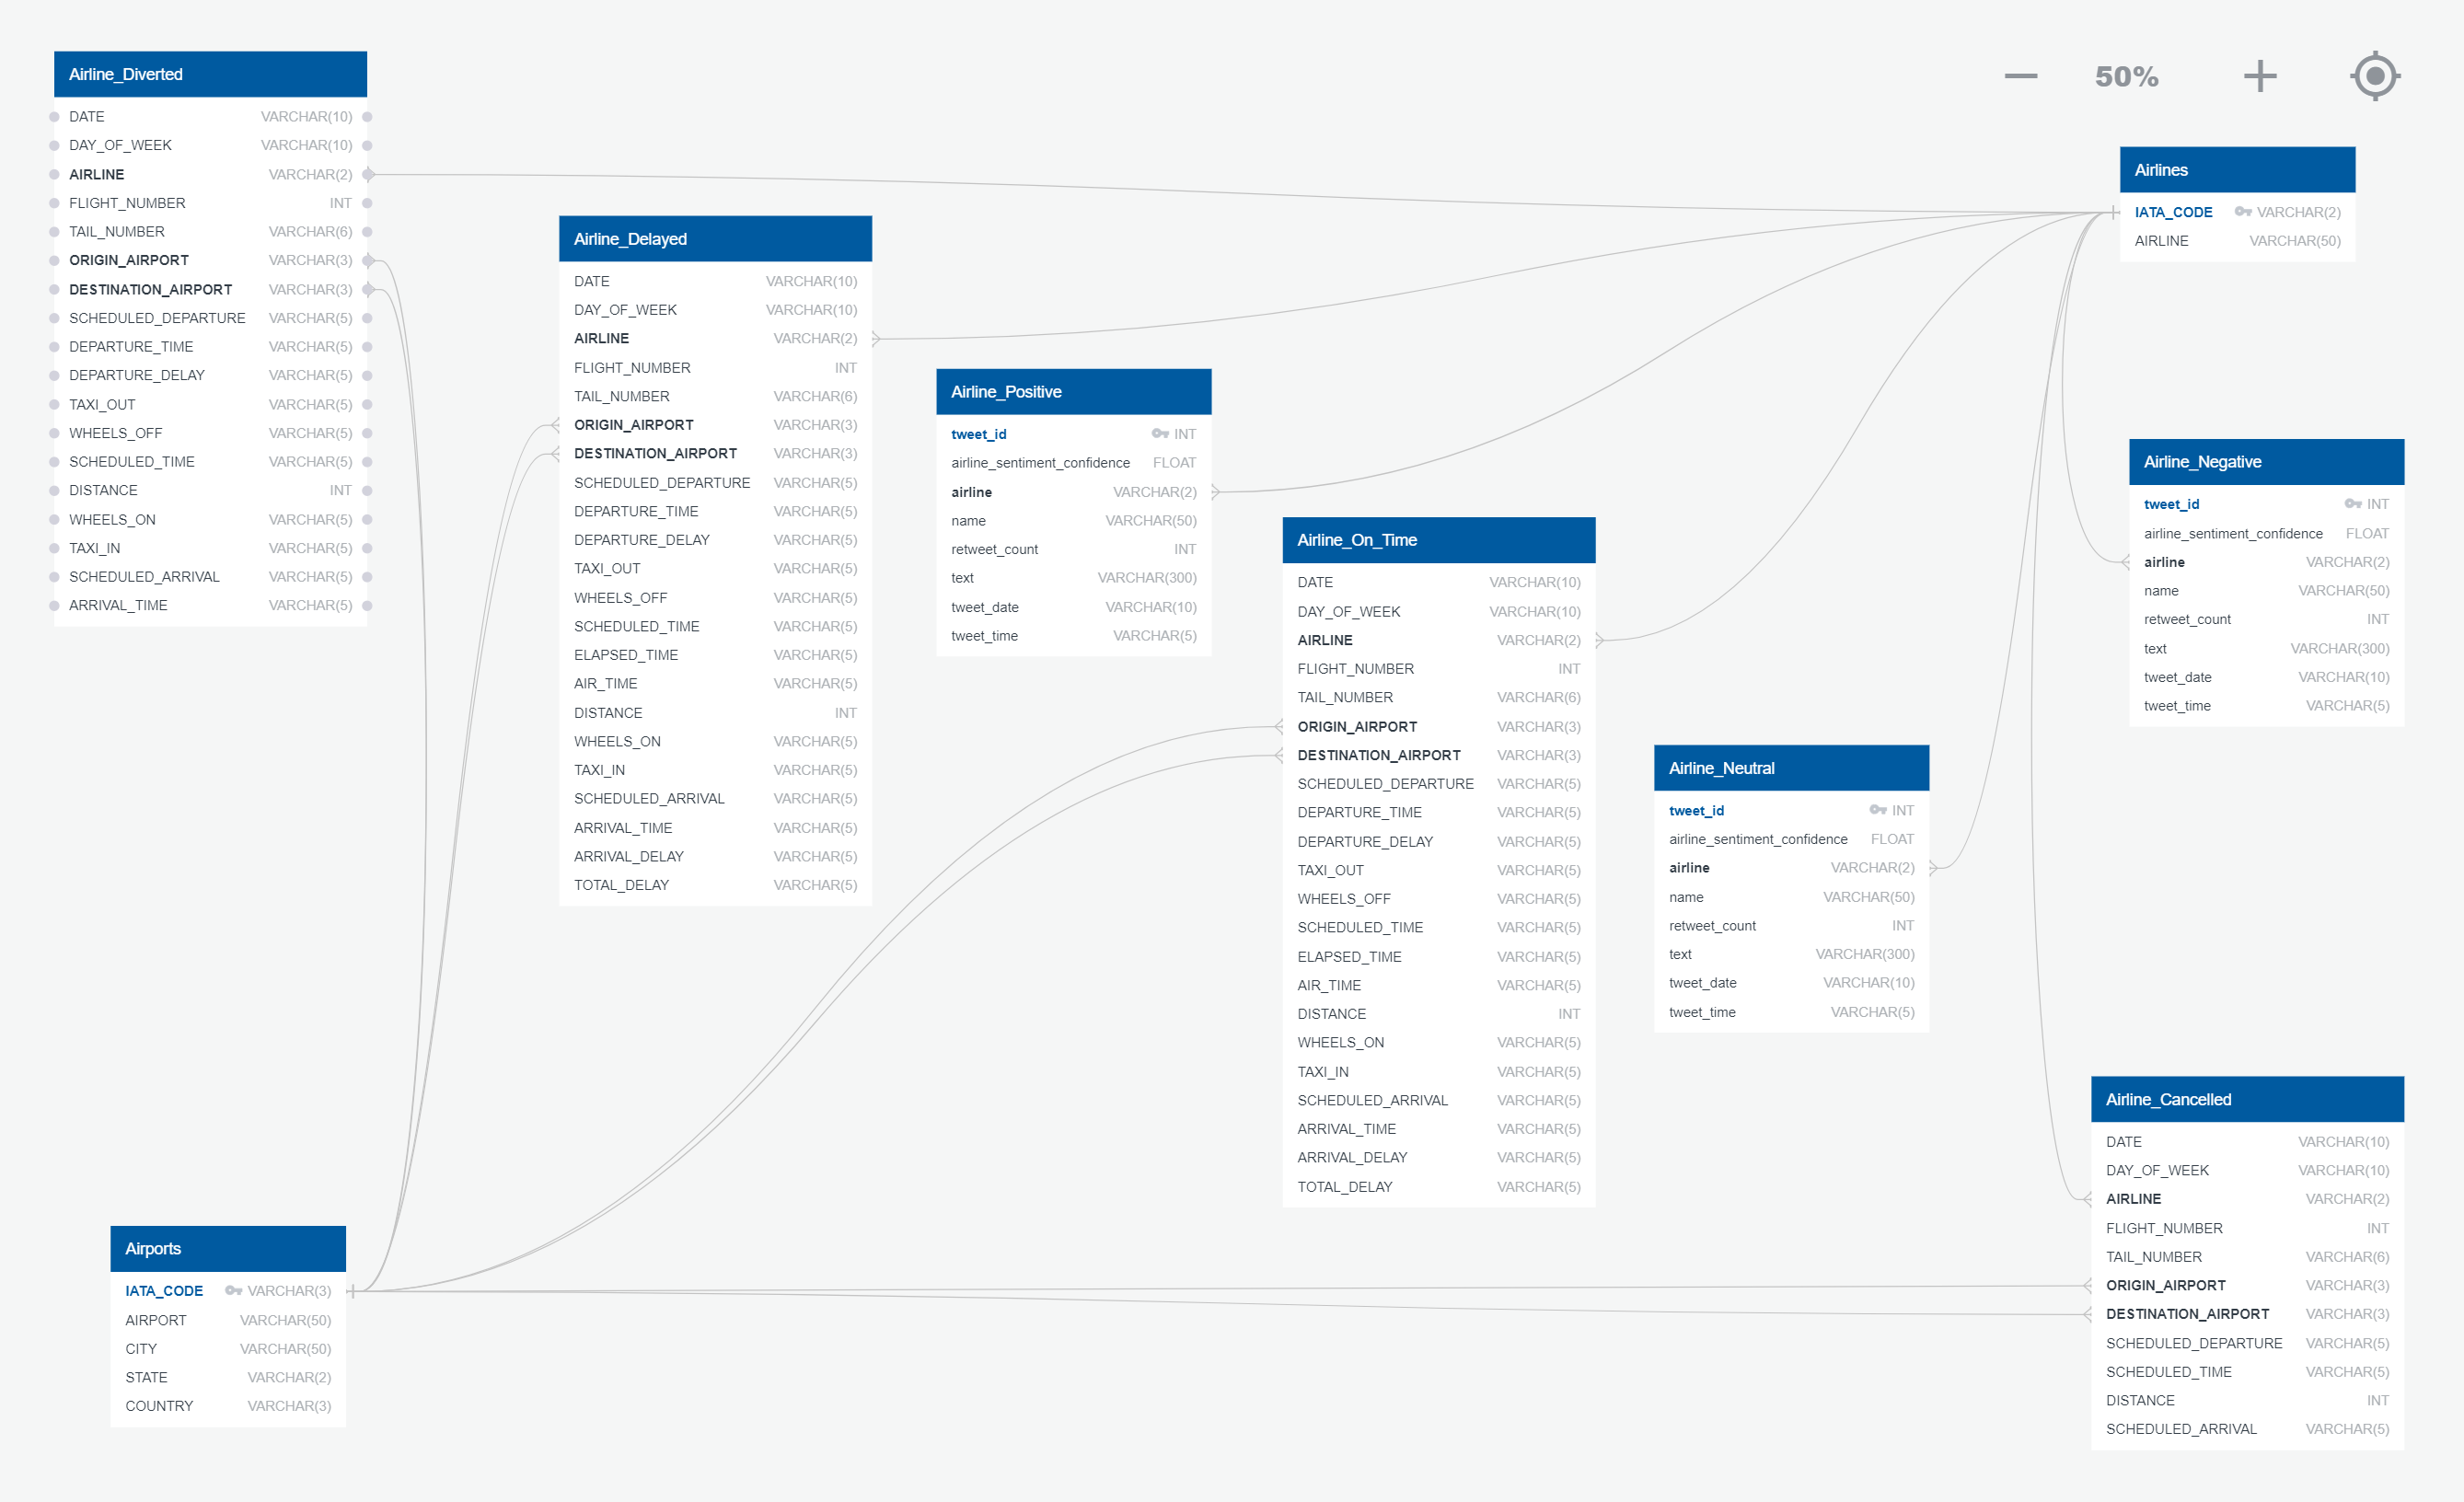

In [ ]:
#ADD CODE HERE

# Project Analysis (Matt)

The purpose of this project was to perform an Extract-Transform-Load (ETL) process on Feruary 2015 airline flight performance and customer tweets, based on datasets obtained from Kaggle. The SQLAlchemy and Pandas modules in Python were used to import, clean, and process the data, while the former was used to output the transformed data into an SQL database. Discussed below are the specific actions taken to perform each step of the ETL process.

## Data Extraction

The extraction phase of the ETL process included importing and inspecting the data, with the latter including the identification all issues and inconsistencies with the source data. To begin, there were four files that needed to be imported, which included three CSV files and one SQLite database file. A Pandas data frame was created for each of the former, which contained flight, airline, and airport information respectively. Before importing the latter, a connection was established through the SQLite engine to the database file and the table name was exported. The tweet information table was then extracted from the database directly to a Pandas data frame for inspection.

With the import process complete, the next step was to thoroughly inspect each of the data frames. Upon the completion of this process, several issues and inconsistencies were found. First, the date range of the customer tweet data was narrower than the date range of the flight performance data. Second, several columns in the flight information and tweet information data frames were missing large amounts of data. Third, the date and time values were not consistent between the flight and tweet information data frames. Fourth, the tweet information data frame contained fewer airlines than the flight information data frame. Finally, the latitude and longitude information for certain airports was incomplete in the airport information data frame.

## Data Transformation

Having established the issues with the imported data, the first step in the transformation phase was to clean each of the data frames. This was a multi-step process for each data frame, starting with the flight information data frame. TBD

## Data Loading

TBD